In [1]:
TTS_PATH = "../../"

In [2]:
import os
import sys
# sys.path.append(TTS_PATH) # set this if TTS is not installed globally
import glob
import librosa
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.tts.datasets.preprocess import *
%matplotlib inline

In [3]:
! head ../../../datasets/LJSpeech-1.1/metadata.csv

LJ001-0001|Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition|Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
LJ001-0002|in being comparatively modern.|in being comparatively modern.
LJ001-0003|For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process|For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process
LJ001-0004|produced the block books, which were the immediate predecessors of the true printed book,|produced the block books, which were the immediate predecessors of the true printed book,
LJ001-0005|the invention of movable metal letters in the middle of the fifteenth century may justl

In [4]:
DATA_PATH = "../../../freynman/data/downloaded/cut_wavs"
NUM_PROC = 1 # num of workers

In [5]:
! ls ../../../freynman/data/downloaded/cut_wavs

probability_and_uncertainty
seeking_new_laws
symmetry_in_physical_law
the_distiction_of_past_and_future
the_great_conservation_principles
the_law_of_gravitation_an_example_of_physical_law
the_relation_of_mathematics_and_physics


In [6]:
os.listdir("../../../freynman/data/downloaded/cut_wavs")

['the_great_conservation_principles',
 'the_law_of_gravitation_an_example_of_physical_law',
 'the_distiction_of_past_and_future',
 'symmetry_in_physical_law',
 'probability_and_uncertainty',
 'seeking_new_laws',
 'the_relation_of_mathematics_and_physics']

In [7]:
def feynman(root, metadata=None):
    audio_list = os.listdir(root)
    items = []
    speaker_name = "feynman"
    for path in audio_list:
        if not os.path.isdir(os.path.join(root, path)):
            continue
        df_meta = pd.read_csv(os.path.join(root, path, "metadata.csv"))
        for i, row in df_meta.iterrows():
            audio_path = os.path.join(root, path, row['path'])
            items.append([row['sub'], audio_path, speaker_name])
        
    return items    

In [8]:
# use your own preprocessor at this stage - TTS/datasets/proprocess.py
items = feynman("../../../freynman/data/downloaded/cut_wavs")
print(" > Number of audio files: {}".format(len(items)))

 > Number of audio files: 5135


In [9]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = item[1].strip()
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(waf_path)

In [10]:
# show duplicate items
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


In [11]:
def load_item(item):
    file_name = item[1].strip()
    text = item[0].strip()
    audio = librosa.load(file_name, sr=None)
    sr = audio[1]
    audio = audio[0]
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(NUM_PROC) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

100%|██████████| 5135/5135 [00:22<00:00, 225.94it/s]


In [12]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

100%|██████████| 5135/5135 [00:00<00:00, 62472.45it/s]

 > Number of words: 7875


In [13]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

100%|██████████| 5135/5135 [00:00<00:00, 590237.08it/s]


In [14]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

### Avg audio length per char

In [15]:
for item in data:
    if item[-1] < 2:
        print(item)

('../../../freynman/data/downloaded/cut_wavs/the_great_conservation_principles/code_name_315096.0_316846.0.wav', 'I’ll mention one or two of those.', 33, array([-0.00111389, -0.00137329, -0.0015564 , ...,  0.00048828,
        0.00039673,  0.00030518], dtype=float32), 1.75)
('../../../freynman/data/downloaded/cut_wavs/the_great_conservation_principles/code_name_508936.0_510496.0.wav', 'and I start with the one about charge', 37, array([ 1.5869141e-03,  1.5563965e-03,  1.4648438e-03, ...,
        6.2561035e-04,  6.1035156e-05, -5.6457520e-04], dtype=float32), 1.56)
('../../../freynman/data/downloaded/cut_wavs/the_great_conservation_principles/code_name_518496.0_520376.0.wav', 'So that’s the first.', 20, array([0.0005188 , 0.00057983, 0.00073242, ..., 0.00061035, 0.00064087,
       0.00057983], dtype=float32), 1.88)
('../../../freynman/data/downloaded/cut_wavs/the_great_conservation_principles/code_name_590136.0_591946.0.wav', 'but light comes out.', 20, array([ 0.0274353 ,  0.02783203,  

In [16]:
sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
# sec_per_char /= len(data)
# print(sec_per_char)

In [17]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)

0.07626418401610002
0.2654546707239926


In [18]:
dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    pdf =norm.pdf(sec_per_char)
    if pdf < 0.39:
        print(item)

('../../../freynman/data/downloaded/cut_wavs/the_great_conservation_principles/code_name_250.0_28000.0.wav', '##front [BBC TV Film Leader]', 28, array([-3.0517578e-05, -1.5258789e-05, -3.0517578e-05, ...,
        1.0375977e-03,  1.6174316e-03,  2.0751953e-03], dtype=float32), 27.75)
('../../../freynman/data/downloaded/cut_wavs/the_great_conservation_principles/code_name_28000.0_82950.0.wav', '##front Credits: Cornell University U.S.A., The Character of Physical Law, Professor Richard Feynman gives the Messenger Lectures', 129, array([0.00234985, 0.00253296, 0.00256348, ..., 0.00079346, 0.00057983,
       0.00048828], dtype=float32), 54.95)
('../../../freynman/data/downloaded/cut_wavs/the_great_conservation_principles/code_name_83450.0_101296.0.wav', '##Title The Great Conservation Principles', 41, array([0.00123596, 0.00143433, 0.00170898, ..., 0.00112915, 0.00111389,
       0.0012207 ], dtype=float32), 17.846)
('../../../freynman/data/downloaded/cut_wavs/the_great_conservation_princip

### Plot Dataset Statistics

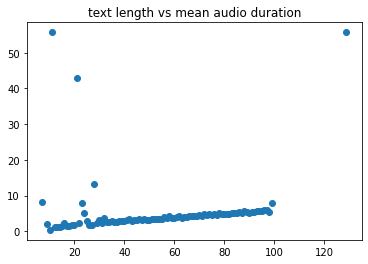

In [19]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

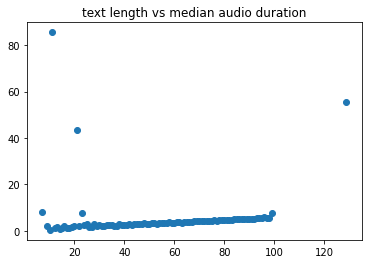

In [20]:
plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

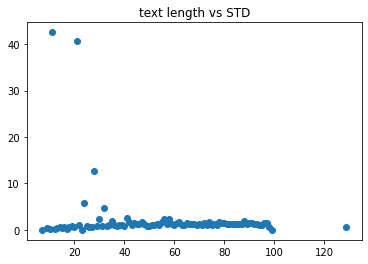

In [21]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

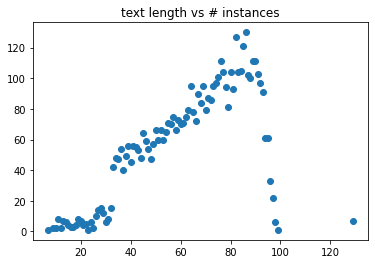

In [22]:
plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

### Check words frequencies

In [23]:
w_count_df = pd.DataFrame.from_dict(w_count, orient='index')
w_count_df.sort_values(0, ascending=False, inplace=True)

In [27]:
w_count_df.head(20)

,0
the,4326
of,1934
that,1512
and,1496
to,1482
a,1436
is,1153
in,1131
it,939
you,785
